# Evaluating KANs vs MLPs for MNIST Classification in FL

This notebook is based mainly on the Flower Tutorial "Use a federated learning strategy", found in https://flower.ai/docs/framework/tutorial-series-use-a-federated-learning-strategy-pytorch.html .

## Global Values

In [1]:
NUM_PARTITIONS = 100
BATCH_SIZE = 64
LOCAL_EPOCHS = 5
FRACTION_CLIENTS = 0.1
COMM_ROUNDS = 100
NET_TYPE = "kan"
LEARNING_RATE = 0.1
MOMENTUM = 0.9
HISTORY = {}
TRY_DEVICE = "cuda" # 'cuda' for gpu
SEED = 249

## Dependencies

In [2]:
!pip install -q flwr[simulation] flwr-datasets[vision] torch torchvision

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.1/65.1 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.9/3.9 MB 15.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.1/542.1 kB 10.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 172.0/172.0 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.3/8.3 MB 20.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.6/294.6 kB 12.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 22.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 465.1/465.1 kB 22.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.0/73.0 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/19

In [3]:
# Efficient KAN
!pip install -q git+https://github.com/Blealtan/efficient-kan.git

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 342.3/342.3 kB 5.9 MB/s eta 0:00:00


In [4]:
!pip install -q git+https://github.com/ZiyaoLi/fast-kan.git

  Preparing metadata (setup.py) ... done


In [5]:
from collections import OrderedDict
from typing import Dict, List, Optional, Tuple

import random
import os
import re
import json
from logging import INFO

from google.colab import drive

import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

import flwr
from flwr.client import Client, ClientApp, NumPyClient
from flwr.server import ServerApp, ServerConfig, ServerAppComponents, SimpleClientManager
from flwr.server.strategy import FedAvg, FedAdagrad
from flwr.simulation import run_simulation, start_simulation
from flwr_datasets import FederatedDataset
from flwr_datasets.partitioner import PathologicalPartitioner, NaturalIdPartitioner
from flwr_datasets.visualization import plot_label_distributions
from flwr.common import ndarrays_to_parameters, NDArrays, Scalar, Context, Metrics
from flwr.common.logger import log
from flwr.server.client_proxy import ClientProxy
from flwr.server.criterion import Criterion
from flwr_datasets.preprocessor import Divider

from efficient_kan import KAN
from fastkan import FastKAN

DEVICE = torch.device(TRY_DEVICE)  # "cpu" or "cuda" ("mps" for Apple Silicon)
print(f"Training on {DEVICE}")
print(f"Flower {flwr.__version__} / PyTorch {torch.__version__}")

Training on cuda
Flower 1.11.1 / PyTorch 2.4.1+cu121


## Mount Google Drive

In [6]:
drive.mount('/content/drive')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Mounted at /content/drive


## Configuring Seeds

In [7]:
torch.manual_seed(SEED)
random.seed(SEED)
np.random.seed(SEED)
os.environ["PYTHONHASHSEED"] = str(SEED)
# torch.use_deterministic_algorithms(True)
# torch.backends.cudnn.benchmark = False
# torch.backends.cudnn.deterministic = True

## Data loading

In [8]:
def create_flower_dataset():
    # Like FedProx partition, but clients have similar number of examples
    partitioner = PathologicalPartitioner(
        num_partitions=NUM_PARTITIONS,
        partition_by="label",
        num_classes_per_partition=2,
        shuffle=True,
        seed=SEED
        )

    fds = FederatedDataset(
        dataset="mnist",
        partitioners={"train": partitioner},
        shuffle=True,
        seed=SEED
        )

    return fds


In [9]:
def load_datasets(partition_id: int, num_partitions: int):

    pytorch_transforms = transforms.Compose(
        [transforms.ToTensor(),
         transforms.Normalize((0.5,), (0.5,)),
         transforms.Lambda(lambda x: torch.flatten(x))  # Flatten the image into a 1D tensor
         ]
    )

    def apply_transforms(batch):
        batch["image"] = [pytorch_transforms(img) for img in batch["image"]]
        return batch

    fds = create_flower_dataset()

    partition = fds.load_partition(partition_id, split="train").with_transform(apply_transforms)
    trainloader = DataLoader(partition, batch_size=BATCH_SIZE, shuffle=True,
                            #  worker_init_fn=seed_worker, generator=g
                             )

    testset = fds.load_split("test").with_transform(apply_transforms)
    testloader = DataLoader(testset, batch_size=BATCH_SIZE,
                            # worker_init_fn=seed_worker, generator=g
                            )

    return trainloader, testloader

### Partition Visualization

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/60000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/10000 [00:00<?, ? examples/s]

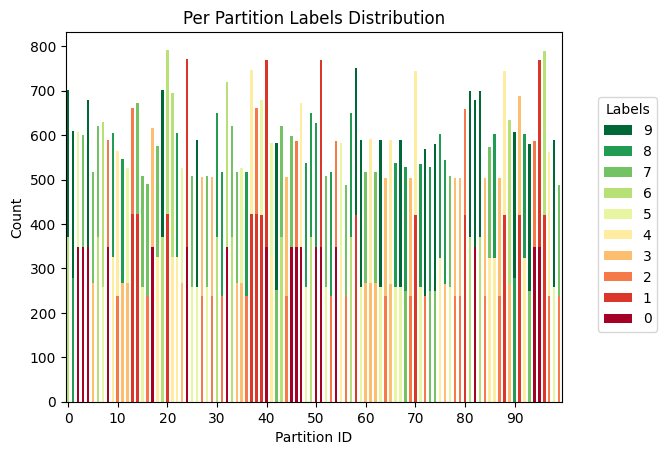

In [10]:
visual_fds = create_flower_dataset()
visual_partitioner = visual_fds.partitioners["train"]
fig, ax, partition_df = plot_label_distributions(
    visual_partitioner,
    label_name="label",
    plot_type="bar",
    size_unit="absolute",
    partition_id_axis="x",
    legend=True,
    verbose_labels=True,
    title="Per Partition Labels Distribution",
    plot_kwargs={"xticks": range(0, NUM_PARTITIONS, 10)},
)

In [11]:
partition_df

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,0,1,2,3,4,5,6,7,8,9
Partition ID,,,,,,,,,,
0,0,0,0,0,0,0,370,0,0,331
1,0,0,0,0,0,0,0,0,279,331
2,349,0,0,0,0,259,0,0,0,0
3,349,0,0,0,0,0,0,251,0,0
4,349,0,0,0,0,0,0,0,0,331
...,...,...,...,...,...,...,...,...,...,...
95,348,421,0,0,0,0,0,0,0,0
96,0,421,0,0,0,0,369,0,0,0
97,0,0,238,0,324,0,0,0,0,0


### Statistics for Number of Examples per Partition

In [12]:
partition_df.sum(1).describe()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,0
count,100.00000
mean,600.00000
std,81.62615
min,488.00000
25%,525.00000
50%,588.50000
75%,651.50000
max,792.00000


### Calculate Mean Number of Updates Per Round

In [13]:
(partition_df.sum(1) / BATCH_SIZE).apply(np.ceil)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,0
Partition ID,
0,11.0
1,10.0
2,10.0
3,10.0
4,11.0
...,...
95,13.0
96,13.0
97,9.0


## Model training/evaluation (PyTorch)

In [14]:
class MLPNet(nn.Module):

    def __init__(self) -> None:
        super(MLPNet, self).__init__()
        self.layer1 = nn.Linear(28 * 28, 200)  # 28 x 28 pixels
        self.layer2 = nn.Linear(200, 200)  # 2 hidden layers with 200 neurons each
        self.layer3 = nn.Linear(200, 10)  # 10 classes
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.relu(self.layer1(x))
        x = self.relu(self.layer2(x))
        x = self.softmax(self.layer3(x))
        return x

class KANNet(KAN):
    def __init__(self) -> None:
        super().__init__([28 * 28, 24, 24, 10])

class FastKANNet(FastKAN):
    def __init__(self) -> None:
        super().__init__([28 * 28, 24, 24, 10])

def create_network(net_type: str):
    if net_type == "mlp":
        return MLPNet()
    elif net_type == "kan":
        return KANNet()
    elif net_type == "fastkan":
        return FastKANNet()
    else:
        raise ValueError(f"Unknown network type: {net_type}")

def get_parameters(net) -> List[np.ndarray]:
    return [val.cpu().numpy() for _, val in net.state_dict().items()]


def set_parameters(net, parameters: List[np.ndarray]):
    params_dict = zip(net.state_dict().keys(), parameters)
    state_dict = OrderedDict({k: torch.Tensor(v) for k, v in params_dict})
    net.load_state_dict(state_dict, strict=True)


def train(net, trainloader, epochs: int):
    """Train the network on the training set."""
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(
        net.parameters(),
        lr=LEARNING_RATE,
        momentum=MOMENTUM)
    net.train()
    for epoch in range(epochs):
        correct, total, epoch_loss = 0, 0, 0.0
        for batch in trainloader:
            images, labels = batch["image"], batch["label"]
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            optimizer.zero_grad()
            outputs = net(images)
            loss = criterion(net(images), labels)
            loss.backward()
            optimizer.step()
            # Metrics
            epoch_loss += loss
            total += labels.size(0)
            correct += (torch.max(outputs.data, 1)[1] == labels).sum().item()
        epoch_loss /= len(trainloader.dataset)
        epoch_acc = correct / total
        print(f"Epoch {epoch+1}: train loss {epoch_loss}, accuracy {epoch_acc}")
        return epoch_loss, epoch_acc


def test(net, testloader):
    """Evaluate the network on the entire test set."""
    criterion = torch.nn.CrossEntropyLoss()
    correct, total, loss = 0, 0, 0.0
    net.eval()
    with torch.no_grad():
        for batch in testloader:
            images, labels = batch["image"], batch["label"]
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            outputs = net(images)
            loss += criterion(outputs, labels).item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    loss /= len(testloader.dataset)
    accuracy = correct / total
    return loss, accuracy

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Flower Architecture

### Flower client

In [15]:
class FlowerClient(NumPyClient):
    def __init__(self, pid, net, trainloader, valloader=None):
        self.pid = pid  # partition ID of a client
        self.net = net
        self.trainloader = trainloader
        self.valloader = valloader

    def get_parameters(self, config):
        print(f"[Client {self.pid}] get_parameters")
        return get_parameters(self.net)

    def fit(self, parameters, config):
        # Read values from config
        server_round = config["server_round"]
        local_epochs = config["local_epochs"]

        # Use values provided by the config
        print(f"[Client {self.pid}, round {server_round}] fit, config: {config}")
        set_parameters(self.net, parameters)
        epoch_loss, epoch_accuracy = train(self.net, self.trainloader, epochs=local_epochs)
        return get_parameters(self.net), len(self.trainloader), {"epoch_loss": float(epoch_loss),
                                                                 "epoch_accuracy": float(epoch_accuracy)}

    def evaluate(self, parameters, config):
        print(f"[Client {self.pid}] evaluate, config: {config}")
        set_parameters(self.net, parameters)
        loss, accuracy = test(self.net, self.valloader)
        return float(loss), len(self.valloader), {"accuracy": float(accuracy)}


def client_fn(context: Context) -> Client:
    net = create_network(NET_TYPE).to(DEVICE)
    partition_id = context.node_config["partition-id"]
    num_partitions = context.node_config["num-partitions"]
    trainloader, _ = load_datasets(partition_id, num_partitions)
    return FlowerClient(partition_id, net, trainloader).to_client()

### Server-side parameter **evaluation**

#### Save evaluation results

In [16]:
def create_new_history():
    history = {"net_type": NET_TYPE,
              "test_accuracy": [],
              "test_loss": [],
              "train_accuracy": [0.0], # No fit metrics before the first round
              "train_loss": [0.0],
              "execution_time": 0,
              "seed": SEED,
              "batch_size": BATCH_SIZE,
              "local_epochs": LOCAL_EPOCHS,
              "fraction_clients": FRACTION_CLIENTS,
              "comm_rounds": COMM_ROUNDS,
              "num_partitions": NUM_PARTITIONS,
              "device": str(DEVICE),
              "learning_rate": LEARNING_RATE,
              "momentum": MOMENTUM,
              }
    return history

# Need to use a global var because we can't pass our dictionary as argument
def save_test_metrics(server_round: int, accuracy: float, loss: float):
    HISTORY["test_accuracy"].append((accuracy, server_round))
    HISTORY["test_loss"].append((loss, server_round))

# Currently can't capture the server round inside the fit aggregation function
def save_train_metrics(accuracy: float, loss: float):
    HISTORY["train_accuracy"].append(accuracy)
    HISTORY["train_loss"].append(loss)

def save_execution_time(execution_time: float):
    HISTORY["execution_time"] = execution_time

#### Evaluation function

In [17]:
# The `evaluate` function will be called by Flower after every round
def evaluate(
    server_round: int,
    parameters: NDArrays,
    config: Dict[str, Scalar],
) -> Optional[Tuple[float, Dict[str, Scalar]]]:
    net = create_network(NET_TYPE).to(DEVICE)
    _, testloader = load_datasets(0, NUM_PARTITIONS)
    set_parameters(net, parameters)  # Update model with the latest parameters
    loss, accuracy = test(net, testloader)
    print(f"Server-side evaluation loss {loss} / accuracy {accuracy}")
    save_test_metrics(server_round, accuracy, loss)
    return loss, {"accuracy": accuracy}

### Training **Configuration** (e.g. epochs)




In [18]:
def fit_config(server_round: int):
    """Return training configuration dict for each round.

    """
    config = {
        "server_round": server_round,  # The current round of federated learning
        "local_epochs": LOCAL_EPOCHS,
    }
    return config

### Flower **Server**

#### Fit (training) Metrics Aggregation

In [19]:
def weighted_average(metrics: List[Tuple[int, Metrics]]) -> Metrics:
    """Inspired by https://github.com/adap/flower/blob/0e7c1b06c32ab90e0d3cf64825ed51eedd715509/examples/custom-mods/server.py"""

    # Get number of examples for each client used for training
    examples = [num_examples for num_examples, _ in metrics]

    # Multiply accuracy of each client by number of examples used
    train_losses = [
        num_examples * float(m["epoch_loss"]) for num_examples, m in metrics
    ]
    train_accuracies = [
        num_examples * float(m["epoch_accuracy"]) for num_examples, m in metrics
    ]

    train_loss = sum(train_losses) / sum(examples)
    train_accuracy = sum(train_accuracies) / sum(examples)

    save_train_metrics(train_accuracy, train_loss)

    # Aggregate and return custom metric (weighted average)
    return {
        "train_loss": sum(train_losses) / sum(examples),
        "train_accuracy": sum(train_accuracies) / sum(examples),
    }

#### Server function

In [20]:
def server_fn(context: Context) -> ServerAppComponents:
    # Create FedAvg strategy
    strategy = FedAvg(
        fraction_fit=FRACTION_CLIENTS,
        fraction_evaluate=0,
        min_fit_clients=1,
        min_evaluate_clients=0,
        min_available_clients=NUM_PARTITIONS,
        initial_parameters=ndarrays_to_parameters(params),
        evaluate_fn=evaluate,
        on_fit_config_fn=fit_config,
        fit_metrics_aggregation_fn=weighted_average,
    )

    config = ServerConfig(num_rounds=COMM_ROUNDS)
    return ServerAppComponents(strategy=strategy, config=config)

## Helpers

### Get simulation execution time from Flower logs

In [21]:
def get_elapsed_time(log_filepath) -> float:
    with open(log_filepath, 'r') as f:
        log_content = f.read()

        pattern = r'Run finished \d+ round\(s\) in (\d+\.\d+)s'
        regex_match = re.search(pattern, log_content)

        if regex_match:
            elapsed_time = float(regex_match.group(1))
            print(f"Simulation execution time: {elapsed_time} seconds")
            return elapsed_time
        else:
            print("Could not find elapsed time.")
            return None

## Simulation

### Global model **initialization**

In [22]:
# Create an instance of the model and get the parameters
initial_model = create_network(NET_TYPE)
params = get_parameters(initial_model)
total_params = sum(p.numel() for p in initial_model.parameters() if p.requires_grad)
print(f"Total number of parameters: {total_params}")

Total number of parameters: 196320


### Run Simulation

In [ ]:
# Define hardware resources
if DEVICE.type == "cuda":
    backend_config = {"client_resources": {"num_gpus": 0.25, "num_cpus": 2}}
else:
    backend_config = {"num_cpus": 2}

# Create Apps
client = ClientApp(client_fn=client_fn)
server = ServerApp(server_fn=server_fn)

# create new history
HISTORY = create_new_history()

# Configure logs
log_id = f"log_{NET_TYPE}_seed_{SEED}"
log_filename = f"{log_id}.txt"
flwr.common.logger.configure(
    identifier=log_id,
    filename=log_filename)

# Run simulation
run_simulation(
    server_app=server,
    client_app=client,
    num_supernodes=NUM_PARTITIONS,
    backend_config=backend_config,
)

save_execution_time(get_elapsed_time(log_filename))

### Serialize Results and Save to Google Drive

In [ ]:
folder = "/content/drive/Shareddrives/fedkan_pilot_mnist_results/"
filename = f"hist_{NET_TYPE}_s{SEED}_r{COMM_ROUNDS}_{str(DEVICE)}.json"
filepath = folder + filename
print(f"Saving to {filepath}")

Saving to /content/drive/Shareddrives/fedkan_pilot_mnist_results/hist_fastkan_s249_r100_cuda.json


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
with open(filepath, 'w') as f:
    json.dump(HISTORY, f, indent=4)

In [ ]:
with open(filepath, 'r') as f:
    x = json.load(f)
x

{'net_type': 'fastkan',
 'test_accuracy': [[0.0988, 0],
  [0.1003, 1],
  [0.1135, 2],
  [0.0974, 3],
  [0.1193, 4],
  [0.098, 5],
  [0.1024, 6],
  [0.1421, 7],
  [0.1135, 8],
  [0.1116, 9],
  [0.0982, 10],
  [0.1009, 11],
  [0.1489, 12],
  [0.1553, 13],
  [0.1148, 14],
  [0.115, 15],
  [0.098, 16],
  [0.1135, 17],
  [0.1032, 18],
  [0.1757, 19],
  [0.0982, 20],
  [0.098, 21],
  [0.0892, 22],
  [0.098, 23],
  [0.1009, 24],
  [0.1428, 25],
  [0.2629, 26],
  [0.098, 27],
  [0.1167, 28],
  [0.1346, 29],
  [0.2038, 30],
  [0.1028, 31],
  [0.076, 32],
  [0.1594, 33],
  [0.1375, 34],
  [0.1622, 35],
  [0.1009, 36],
  [0.1383, 37],
  [0.0982, 38],
  [0.1315, 39],
  [0.1165, 40],
  [0.191, 41],
  [0.1194, 42],
  [0.2065, 43],
  [0.1274, 44],
  [0.1985, 45],
  [0.2434, 46],
  [0.1438, 47],
  [0.2089, 48],
  [0.1975, 49],
  [0.2101, 50],
  [0.1023, 51],
  [0.1877, 52],
  [0.1317, 53],
  [0.1919, 54],
  [0.2169, 55],
  [0.1453, 56],
  [0.1741, 57],
  [0.1363, 58],
  [0.2906, 59],
  [0.2189, 60],
 

## Plot all results

### Gather JSON data from Google Drive

In [23]:
# folder = "/content/drive/Shareddrives/fedkan_pilot_mnist_results/"
folder = "/content/drive/MyDrive/LXAI_FedKAN_Data/"

# Get a list of all JSON files in the folder
json_files = [f for f in os.listdir(folder) if f.endswith('.json')]

# Initialize separate lists for 'kan' and 'mlp' data
kan_data = []
mlp_data = []
fastkan_data = []

# Load and separate the data based on 'net_type'
for json_file in json_files:
    with open(os.path.join(folder, json_file), 'r') as f:
        data = json.load(f)
        if data['net_type'] == 'kan':
            kan_data.append(data)
        elif data['net_type'] == 'mlp':
            mlp_data.append(data)
        elif data['net_type'] == 'fastkan':
            fastkan_data.append(data)

In [25]:
print(f"Number of files: {len(json_files)}")
print(f"Number of 'kan' files: {len(kan_data)}")
print(f"Number of 'mlp' files: {len(mlp_data)}")
print(f"Number of 'fastkan' files: {len(fastkan_data)}")

Number of files: 45
Number of 'kan' files: 15
Number of 'mlp' files: 15
Number of 'fastkan' files: 15


### Extract metrics and hyperparameters from each execution

In [26]:
def aggregate_data(data_list):
    """ Aggregate metrics for a given list of JSON data """
    train_accuracies = []
    test_accuracies = []
    train_losses = []
    test_losses = []
    execution_times = []

    for data in data_list:
        train_accuracies.append([acc for acc in data['train_accuracy'][1:]])  # Skip the first element
        test_accuracies.append([acc[0] for acc in data['test_accuracy'][1:]])  # Skip the first element
        train_losses.append([loss for loss in data['train_loss'][1:]])  # Skip the first element
        test_losses.append([loss[0] for loss in data['test_loss'][1:]])  # Skip the first element
        execution_times.append(data['execution_time'])

    # Convert lists to numpy arrays for easier aggregation
    train_accuracies = np.array(train_accuracies)
    test_accuracies = np.array(test_accuracies)
    train_losses = np.array(train_losses)
    test_losses = np.array(test_losses)
    execution_times = np.array(execution_times)

    # Calculate means and standard deviations
    train_acc_mean = np.mean(train_accuracies, axis=0)
    train_acc_std = np.std(train_accuracies, axis=0)

    test_acc_mean = np.mean(test_accuracies, axis=0)
    test_acc_std = np.std(test_accuracies, axis=0)

    train_loss_mean = np.mean(train_losses, axis=0)
    train_loss_std = np.std(train_losses, axis=0)

    test_loss_mean = np.mean(test_losses, axis=0)
    test_loss_std = np.std(test_losses, axis=0)

    execution_time_mean = np.mean(execution_times)
    execution_time_std = np.std(execution_times)

    return train_acc_mean, train_acc_std, test_acc_mean, test_acc_std, train_loss_mean, train_loss_std, test_loss_mean, test_loss_std, execution_time_mean, execution_time_std

# Aggregate data for 'kan's and 'mlp'
kan_results = aggregate_data(kan_data)
mlp_results = aggregate_data(mlp_data)
fastkan_results = aggregate_data(fastkan_data)

# Assuming all gathered simulation had the same hyperparameters
hyperparameters = (f"lr={kan_data[0]['learning_rate']}, bs={kan_data[0]['batch_size']}, "
                  f"epochs={kan_data[0]['local_epochs']}, frac={kan_data[0]['fraction_clients']}")

# Define the communication rounds (assuming all files have the same number of rounds)
comm_rounds = list(range(1, len(kan_results[0]) + 1))

### Plot all Metrics

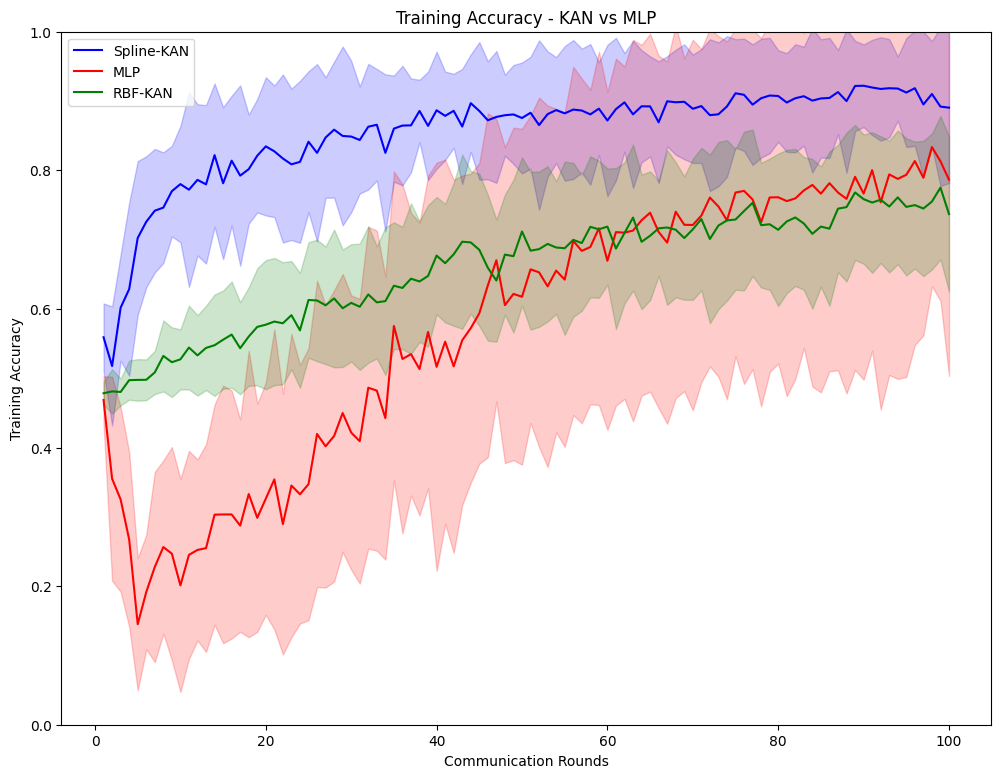

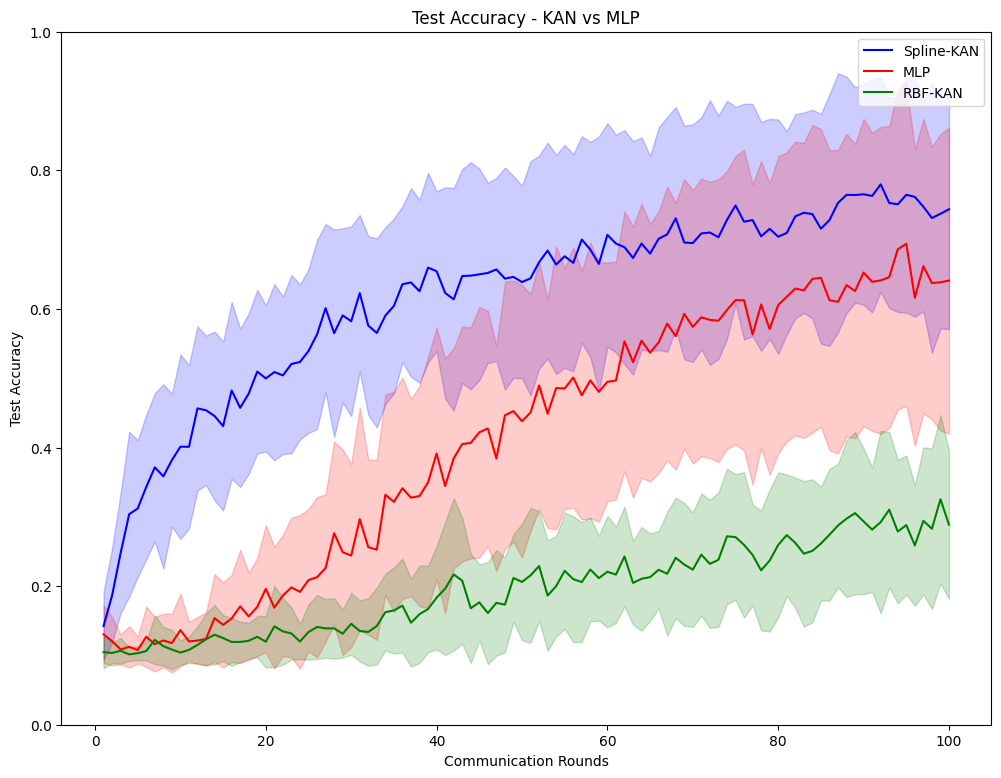

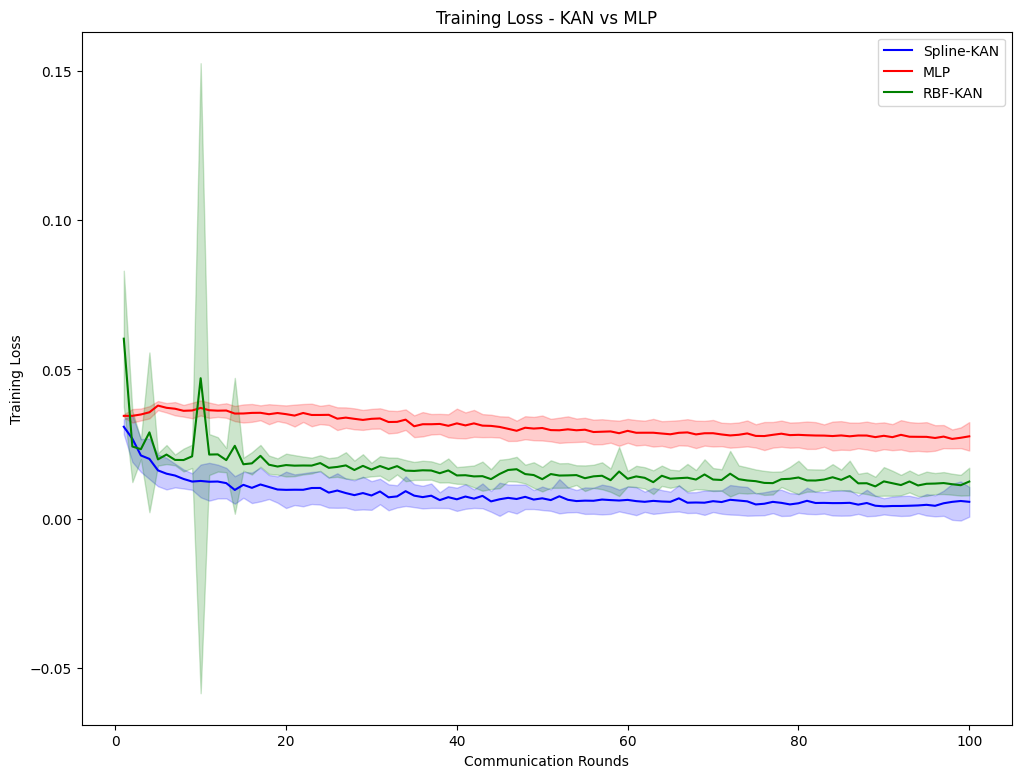

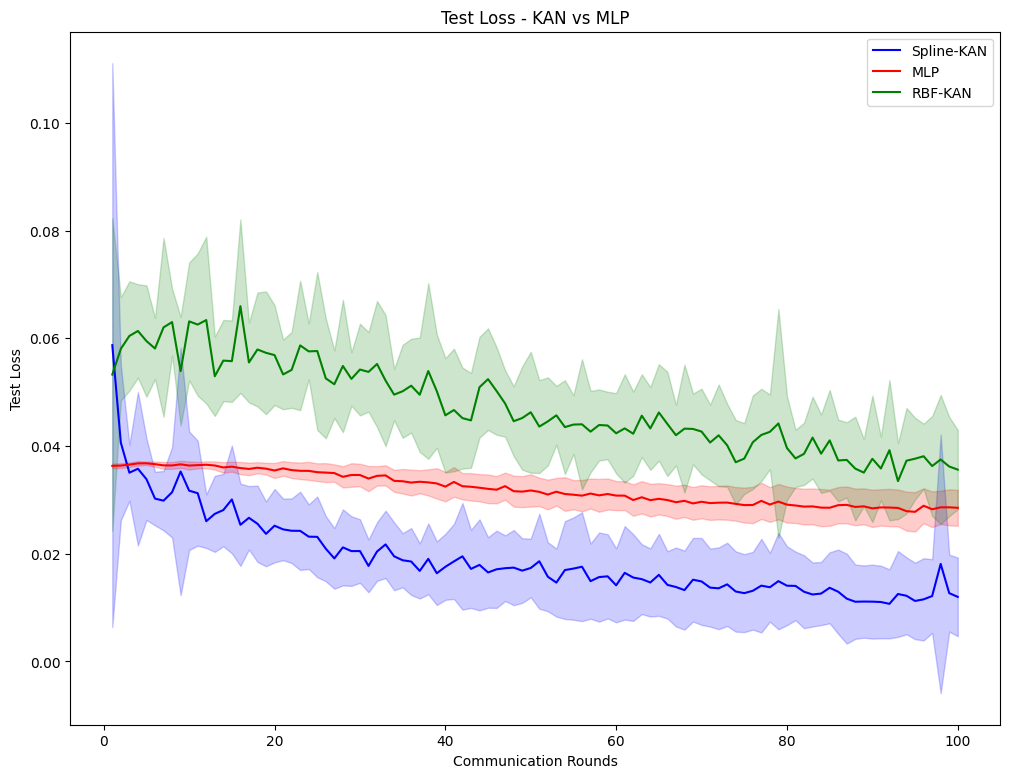

In [30]:
figsize=(12, 9)

# Plot Training Accuracy with error bands for 'kan' and 'mlp'
plt.figure(figsize=figsize)

plt.plot(comm_rounds, kan_results[0], 'b-', label='Spline-KAN')
plt.fill_between(comm_rounds, kan_results[0] - kan_results[1], kan_results[0] + kan_results[1], color='b', alpha=0.2)

plt.plot(comm_rounds, mlp_results[0], 'r-', label='MLP')
plt.fill_between(comm_rounds, mlp_results[0] - mlp_results[1], mlp_results[0] + mlp_results[1], color='r', alpha=0.2)

plt.plot(comm_rounds, fastkan_results[0], 'g-', label='RBF-KAN')
plt.fill_between(comm_rounds, fastkan_results[0] - fastkan_results[1], fastkan_results[0] + fastkan_results[1], color='g', alpha=0.2)

plt.title(f"Training Accuracy - KAN vs MLP")
plt.xlabel("Communication Rounds")
plt.ylabel("Training Accuracy")
plt.ylim(0, 1)
# plt.xticks(comm_rounds)
plt.legend()
plt.show()

# Plot Test Accuracy with error bands for 'kan' and 'mlp'
plt.figure(figsize=figsize)

plt.plot(comm_rounds, kan_results[2], 'b-', label='Spline-KAN')
plt.fill_between(comm_rounds, kan_results[2] - kan_results[3], kan_results[2] + kan_results[3], color='b', alpha=0.2)

plt.plot(comm_rounds, mlp_results[2], 'r-', label='MLP')
plt.fill_between(comm_rounds, mlp_results[2] - mlp_results[3], mlp_results[2] + mlp_results[3], color='r', alpha=0.2)

plt.plot(comm_rounds, fastkan_results[2], 'g-', label='RBF-KAN')
plt.fill_between(comm_rounds, fastkan_results[2] - fastkan_results[3], fastkan_results[2] + fastkan_results[3], color='g', alpha=0.2)

plt.title(f"Test Accuracy - KAN vs MLP")
plt.xlabel("Communication Rounds")
plt.ylabel("Test Accuracy")
plt.ylim(0, 1)
# plt.xticks(comm_rounds)
plt.legend()
plt.show()

# Plot Training Loss with error bands for 'kan' and 'mlp'
plt.figure(figsize=figsize)

plt.plot(comm_rounds, kan_results[4], 'b-', label='Spline-KAN')
plt.fill_between(comm_rounds, kan_results[4] - kan_results[5], kan_results[4] + kan_results[5], color='b', alpha=0.2)

plt.plot(comm_rounds, mlp_results[4], 'r-', label='MLP')
plt.fill_between(comm_rounds, mlp_results[4] - mlp_results[5], mlp_results[4] + mlp_results[5], color='r', alpha=0.2)

plt.plot(comm_rounds, fastkan_results[4], 'g-', label='RBF-KAN')
plt.fill_between(comm_rounds, fastkan_results[4] - fastkan_results[5], fastkan_results[4] + fastkan_results[5], color='g', alpha=0.2)

plt.title(f"Training Loss - KAN vs MLP")
plt.xlabel("Communication Rounds")
plt.ylabel("Training Loss")
# plt.xticks(comm_rounds)
plt.legend()
plt.show()

# Plot Test Loss with error bands for 'kan' and 'mlp'
plt.figure(figsize=figsize)

plt.plot(comm_rounds, kan_results[6], 'b-', label='Spline-KAN')
plt.fill_between(comm_rounds, kan_results[6] - kan_results[7], kan_results[6] + kan_results[7], color='b', alpha=0.2)

plt.plot(comm_rounds, mlp_results[6], 'r-', label='MLP')
plt.fill_between(comm_rounds, mlp_results[6] - mlp_results[7], mlp_results[6] + mlp_results[7], color='r', alpha=0.2)

plt.plot(comm_rounds, fastkan_results[6], 'g-', label='RBF-KAN')
plt.fill_between(comm_rounds, fastkan_results[6] - fastkan_results[7], fastkan_results[6] + fastkan_results[7], color='g', alpha=0.2)

plt.title(f"Test Loss - KAN vs MLP")
plt.xlabel("Communication Rounds")
plt.ylabel("Test Loss")
# plt.xticks(comm_rounds)
plt.legend()
plt.show()

In [31]:
print(f"Execution time for KAN: {kan_results[8]} ± {kan_results[9]} seconds")
print(f"Execution time for MLP: {mlp_results[8]} ± {mlp_results[9]} seconds")
print(f"Execution time for FastKAN: {fastkan_results[8]} ± {fastkan_results[9]} seconds")


Execution time for KAN: 4192.0453333333335 ± 1183.3402265218947 seconds
Execution time for MLP: 3593.3079999999995 ± 124.09729168143302 seconds
Execution time for FastKAN: 3640.27 ± 114.351591797695 seconds


## Hypothesis Testing

### Convert to Pandas Dataframe and Process Data

In [ ]:
import pandas as pd
df_kan = pd.DataFrame(kan_data)
df_mlp = pd.DataFrame(mlp_data)
df_fastkan = pd.DataFrame(fastkan_data)

In [ ]:
# Function to process the dataframe as described by the user
def process_dataframe(df):
    # Step 1: Remove the columns 'train_accuracy', 'test_loss', 'train_loss'
    df = df.drop(columns=['train_accuracy', 'test_loss', 'train_loss'])

    # Step 2: Modify the 'test_accuracy' column
    # Removing the first pair (round 0) and keeping only the accuracy value from remaining pairs
    df['test_accuracy'] = df['test_accuracy'].apply(lambda x: [pair[0] for pair in x[1:]])

    # Step 3: Create new columns r10, r20, r30, ..., r100
    for i in range(1, 11):
        df[f'r{i*10}'] = df['test_accuracy'].apply(lambda x: x[i*10-1])

    return df

processed_kan_data = process_dataframe(df_kan)
processed_mlp_data = process_dataframe(df_mlp)
processed_fastkan_data = process_dataframe(df_fastkan)

In [ ]:
processed_kan_data.head(3)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,net_type,test_accuracy,execution_time,seed,batch_size,local_epochs,fraction_clients,comm_rounds,num_partitions,device,...,r10,r20,r30,r40,r50,r60,r70,r80,r90,r100
0,kan,"[0.1016, 0.2492, 0.1044, 0.4034, 0.291, 0.2495...",4118.1100000000,235,64,5,0.1000000000,100,100,cuda,...,0.4750000000,0.6416000000,0.5671000000,0.7452000000,0.5801000000,0.8144000000,0.8811000000,0.7934000000,0.8175000000,0.7750000000
1,kan,"[0.1045, 0.2041, 0.3883, 0.3343, 0.27, 0.4821,...",3757.9400000000,236,64,5,0.1000000000,100,100,cuda,...,0.5557000000,0.5128000000,0.4125000000,0.6912000000,0.6321000000,0.7664000000,0.7456000000,0.7441000000,0.8067000000,0.8121000000
2,kan,"[0.1821, 0.1217, 0.2319, 0.2844, 0.2624, 0.225...",3562.0900000000,237,64,5,0.1000000000,100,100,cuda,...,0.4051000000,0.5769000000,0.5459000000,0.4545000000,0.7279000000,0.7372000000,0.6692000000,0.5741000000,0.6333000000,0.6378000000


### Get Accuracy Means for Selected Rounds

In [ ]:
rounds = [f'r{i*10}' for i in range(1, 11)]

#### Spline-KAN Accuracy Means

In [ ]:
processed_kan_data[rounds].describe().round(3).T

,count,mean,std,min,25%,50%,75%,max
r10,15.0,0.401,0.138,0.204,0.271,0.428,0.487,0.596
r20,15.0,0.500,0.109,0.210,0.477,0.498,0.575,0.642
r30,15.0,0.582,0.142,0.196,0.551,0.624,0.669,0.753
r40,15.0,0.654,0.119,0.358,0.646,0.676,0.734,0.804
r50,15.0,0.639,0.144,0.197,0.594,0.659,0.717,0.824
r60,15.0,0.707,0.167,0.215,0.678,0.739,0.822,0.832
r70,15.0,0.695,0.177,0.160,0.681,0.751,0.770,0.881
r80,15.0,0.704,0.175,0.143,0.653,0.775,0.808,0.828
r90,15.0,0.765,0.165,0.239,0.739,0.826,0.858,0.875
r100,15.0,0.744,0.179,0.298,0.753,0.812,0.837,0.909


#### RBF-KAN Accuracy Means

In [ ]:
processed_fastkan_data[rounds].describe().round(3).T

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,count,mean,std,min,25%,50%,75%,max
r10,15.0,0.104,0.018,0.089,0.097,0.098,0.098,0.151
r20,15.0,0.120,0.039,0.089,0.098,0.099,0.128,0.198
r30,15.0,0.146,0.046,0.097,0.107,0.141,0.174,0.257
r40,15.0,0.183,0.077,0.061,0.128,0.181,0.221,0.348
r50,15.0,0.206,0.087,0.101,0.120,0.205,0.268,0.376
r60,15.0,0.221,0.083,0.098,0.170,0.204,0.312,0.336
r70,15.0,0.224,0.085,0.098,0.167,0.192,0.290,0.397
r80,15.0,0.259,0.108,0.098,0.203,0.266,0.334,0.464
r90,15.0,0.293,0.109,0.104,0.220,0.282,0.350,0.476
r100,15.0,0.289,0.111,0.130,0.216,0.282,0.353,0.476


#### MLP Accuracy Means

In [ ]:
processed_mlp_data[rounds].describe().round(3).T

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,count,mean,std,min,25%,50%,75%,max
r10,15.0,0.137,0.054,0.089,0.101,0.103,0.162,0.254
r20,15.0,0.196,0.095,0.096,0.114,0.166,0.272,0.345
r30,15.0,0.244,0.137,0.096,0.111,0.305,0.375,0.431
r40,15.0,0.391,0.188,0.114,0.201,0.463,0.562,0.643
r50,15.0,0.438,0.204,0.114,0.298,0.472,0.600,0.722
r60,15.0,0.495,0.178,0.114,0.493,0.522,0.610,0.676
r70,15.0,0.574,0.204,0.114,0.574,0.627,0.702,0.759
r80,15.0,0.606,0.222,0.114,0.577,0.711,0.728,0.797
r90,15.0,0.652,0.229,0.097,0.661,0.722,0.780,0.841
r100,15.0,0.641,0.229,0.103,0.636,0.738,0.766,0.839


Difference between Accuracy Means for Spline-KAN vs MLP

In [ ]:
(processed_kan_data[rounds].mean() - processed_mlp_data[rounds].mean()).round(3)

,0
r10,0.265
r20,0.304
r30,0.338
r40,0.263
r50,0.201
r60,0.212
r70,0.121
r80,0.099
r90,0.113
r100,0.103


### Apply tests for accuracy

In [ ]:
from scipy.stats import ttest_ind

# Function to apply Welch's t-test
def welchs_ttest(kan_data, mlp_data, round_column):
    # Perform one-sided Welch's t-test (greater test)
    t_stat, p_value = ttest_ind(kan_data[round_column],
                                mlp_data[round_column],
                                equal_var=False,
                                alternative='greater'
                                )

    return t_stat, p_value

# List of rounds (columns)
rounds = [f'r{i*10}' for i in range(1, 11)]

# Dictionary to store t-statistics and p-values for each round
kan_mlp_results = {}
fastkan_mlp_results = {}

# Apply Welch's t-test for both comparisons
for round_col in rounds:
    kan_mlp_t_stat, kan_mlp_p_value = welchs_ttest(processed_kan_data, processed_mlp_data, round_col)
    kan_mlp_results[round_col] = {'t_stat': kan_mlp_t_stat, 'p_value': kan_mlp_p_value}
    fastkan_mlp_t_stat, fastkan_mlp_p_value = welchs_ttest(processed_fastkan_data, processed_mlp_data, round_col)
    fastkan_mlp_results[round_col] = {'t_stat': fastkan_mlp_t_stat, 'p_value': fastkan_mlp_p_value}

# Displaying the results
kan_mlp_results_df = pd.DataFrame(kan_mlp_results).T
fastkan_mlp_results_df = pd.DataFrame(fastkan_mlp_results).T

# Suppress scientific notation and set precision to 10 decimal places
#pd.set_option('display.float_format', lambda x: f'{x:.10f}')
#pd.reset_option('display.float_format')

print("KAN vs MLP:")
display(kan_mlp_results_df.round(4))
print("\nFastKAN vs MLP:")
display(fastkan_mlp_results_df.round(4))

KAN vs MLP:


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,t_stat,p_value
r10,6.9256,0.0000
r20,8.1254,0.0000
r30,6.6535,0.0000
r40,4.5797,0.0001
r50,3.1157,0.0023
r60,3.3648,0.0011
r70,1.7298,0.0474
r80,1.3513,0.0940
r90,1.5486,0.0669
r100,1.3739,0.0905



FastKAN vs MLP:


,t_stat,p_value
r10,-2.1927,0.9788
r20,-2.8842,0.9952
r30,-2.6437,0.9915
r40,-3.9658,0.9996
r50,-4.0480,0.9997
r60,-5.3957,1.0000
r70,-6.1260,1.0000
r80,-5.4344,1.0000
r90,-5.4768,1.0000
r100,-5.3710,1.0000


## Find ratio between execution times

In [ ]:
from scipy import stats

def times_ratio(sample_A, sample_B):
        mean_A = np.mean(sample_A)
        mean_B = np.mean(sample_B)
        return mean_A / mean_B

def calculate_confidence_interval(df_kan, df_mlp, confidence_level=0.95, n_resamples=10000):

    # Perform bootstrap
    res = stats.bootstrap(
        data=(df_kan['execution_time'], df_mlp['execution_time']),
        statistic=times_ratio,
        confidence_level=confidence_level,
        n_resamples=n_resamples,
        method='percentile',
        vectorized=False,
        paired=False,
        random_state=42
    )

    lower_bound = res.confidence_interval.low
    upper_bound = res.confidence_interval.high

    return lower_bound, upper_bound

### Spline-KAN vs MLP

In [ ]:
lower_bound, upper_bound = calculate_confidence_interval(df_kan, df_mlp, confidence_level=0.95)

print(f"{int(confidence_level*100)}% Confidence Interval for beta: ({lower_bound:.2f}, {upper_bound:.2f})")

95% Confidence Interval for beta: (1.02, 1.36)


### RBF-KAN vs MLP

In [ ]:
lower_bound, upper_bound = calculate_confidence_interval(df_fastkan, df_mlp, confidence_level=0.95)

print(f"{int(confidence_level*100)}% Confidence Interval for beta: ({lower_bound:.2f}, {upper_bound:.2f})")

95% Confidence Interval for beta: (0.99, 1.04)


# Estimate Parameters from Zeydan et al. [2024] - [ArXiv](https://arxiv.org/pdf/2407.20100)

We are adapting the authors code from GitHub (https://github.com/ezeydan/F-KANs/blob/main/main.py)

In [ ]:
!pip install pykan

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.3/77.3 kB 2.2 MB/s eta 0:00:00


In [ ]:
import torch
import torch.nn as nn
import numpy as np
from torch.utils.data import DataLoader, TensorDataset, random_split
from sklearn.datasets import load_iris
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_fscore_support
from kan import KAN as PyKAN
import matplotlib.pyplot as plt
import copy
import time


# Split train_dataset for federated learning into 2 clients
num_clients = 2
rounds = 20

# Define the KANClassifier with Dropout layers
class KANClassifier(nn.Module):
    def __init__(self, kan_model, num_classes):
        super(KANClassifier, self).__init__()
        self.kan_model = kan_model
        last_layer_width = kan_model.width[-1]
        if isinstance(last_layer_width, list):
            if len(last_layer_width) == 2:
                last_layer_width = last_layer_width[0]
            else:
                raise ValueError("Unexpected format for kan_model.width[-1]")
        self.fc = nn.Linear(last_layer_width, num_classes)
        self.dropout = nn.Dropout(p=0.5)  # Dropout with 50% probability
        self._initialize_weights()

    def _initialize_weights(self):
        nn.init.kaiming_normal_(self.fc.weight)
        if self.fc.bias is not None:
            nn.init.constant_(self.fc.bias, 0)

    def forward(self, x):
        x = self.kan_model(x)
        x = self.dropout(x)
        x = self.fc(x)
        return x

    def train_kan(self, dataset, steps, lamb, lamb_entropy):
        optimizer = torch.optim.Adam(self.parameters(), lr=0.001, weight_decay=1e-5)  # Added weight decay
        loss_fn = nn.CrossEntropyLoss()
        for step in range(steps):
            optimizer.zero_grad()
            outputs = self(dataset['train_input'].float())
            loss = loss_fn(outputs, dataset['train_label'])
            loss.backward()
            torch.nn.utils.clip_grad_norm_(self.parameters(), max_norm=1.0)
            optimizer.step()

# Define the MLP model with the same depth as KAN
class MLP(nn.Module):
    def __init__(self, input_size, hidden_sizes, output_size):
        super(MLP, self).__init__()
        layers = []
        sizes = [input_size] + hidden_sizes + [output_size]
        for i in range(len(sizes) - 1):
            layers.append(nn.Linear(sizes[i], sizes[i + 1]))
            if i < len(sizes) - 2:
                layers.append(nn.ReLU())
                layers.append(nn.Dropout(p=0.5))  # Dropout with 50% probability
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

    def train_model(self, dataset, steps, learning_rate=0.001):
        optimizer = torch.optim.Adam(self.parameters(), lr=learning_rate, weight_decay=1e-5)  # Added weight decay
        loss_fn = nn.CrossEntropyLoss()
        for step in range(steps):
            optimizer.zero_grad()
            outputs = self(dataset['train_input'].float())
            loss = loss_fn(outputs, dataset['train_label'])
            loss.backward()
            torch.nn.utils.clip_grad_norm_(self.parameters(), max_norm=1.0)
            optimizer.step()

def create_dataset(loader):
    inputs = []
    labels = []
    for data in loader:
        inputs.append(data[0])
        labels.append(data[1])
    inputs = torch.cat(inputs, dim=0)
    labels = torch.cat(labels, dim=0)
    return {
        'train_input': inputs,
        'train_label': labels,
        'test_input': inputs.clone(),
        'test_label': labels.clone()
    }

def fed_avg(global_model, client_models):
    global_state_dict = global_model.state_dict()
    for param_tensor in global_state_dict:
        global_state_dict[param_tensor].zero_()
    for client_model in client_models:
        client_state_dict = client_model.state_dict()
        for param_tensor in global_state_dict:
            global_state_dict[param_tensor] += client_state_dict[param_tensor] / len(client_models)
    global_model.load_state_dict(global_state_dict)
    return global_model

def compute_metrics(model, loader):
    loss_fn = torch.nn.CrossEntropyLoss()
    total_loss = 0
    correct = 0
    total = 0
    all_labels = []
    all_preds = []
    model.training = False
    with torch.no_grad():
        for inputs, labels in loader:
            outputs = model(inputs.float())
            loss = loss_fn(outputs, labels)
            total_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())
    avg_loss = total_loss / len(loader.dataset)
    accuracy = correct / total
    precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average='weighted')
    model.training = True
    return avg_loss, accuracy, precision, recall, f1

def federated_learning_rounds(global_model, client_loaders, test_loader, rounds=rounds, steps=20):
    train_losses = []
    test_losses = []
    train_accuracies = []
    test_accuracies = []
    train_precisions = []
    test_precisions = []
    train_recalls = []
    test_recalls = []
    train_f1s = []
    test_f1s = []

    for round_num in range(rounds):
        client_models = [copy.deepcopy(global_model) for _ in range(len(client_loaders))]
        for i, client_loader in enumerate(client_loaders):
            client_dataset = create_dataset(client_loader)
            print(f"Training client {i+1}/{len(client_loaders)}")
            if isinstance(client_models[i], KANClassifier):
                client_models[i].train_kan(client_dataset, steps, lamb=0.01, lamb_entropy=10.0)
            elif isinstance(client_models[i], MLP):
                client_models[i].train_model(client_dataset, steps)

        global_model = fed_avg(global_model, client_models)

        train_loss, train_accuracy, train_precision, train_recall, train_f1 = compute_metrics(global_model, client_loaders[0])
        test_loss, test_accuracy, test_precision, test_recall, test_f1 = compute_metrics(global_model, test_loader)

        train_losses.append(train_loss)
        test_losses.append(test_loss)
        train_accuracies.append(train_accuracy)
        test_accuracies.append(test_accuracy)
        train_precisions.append(train_precision)
        test_precisions.append(test_precision)
        train_recalls.append(train_recall)
        test_recalls.append(test_recall)
        train_f1s.append(train_f1)
        test_f1s.append(test_f1)

        print(f'Round {round_num+1} - Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}, '
              f'Train Accuracy: {train_accuracy:.4f}, Test Accuracy: {test_accuracy:.4f}, '
              f'Train Precision: {train_precision:.4f}, Test Precision: {test_precision:.4f}, '
              f'Train Recall: {train_recall:.4f}, Test Recall: {test_recall:.4f}, '
              f'Train F1: {train_f1:.4f}, Test F1: {test_f1:.4f}')

    return global_model, train_losses, test_losses, train_accuracies, test_accuracies, train_precisions, test_precisions, train_recalls, test_recalls, train_f1s, test_f1s

# Initialize KAN model with 3 hidden layers and dropout
kan_width = [4, 20, 20, 20]
base_kan_model = PyKAN(width=kan_width, grid=5, k=3, seed=0)
last_layer_width = base_kan_model.width[-1]
if isinstance(last_layer_width, list):
    if len(last_layer_width) == 2:
        last_layer_width = last_layer_width[0]
    else:
        raise ValueError("Unexpected format for kan_model.width[-1]")
kan_global_model = KANClassifier(base_kan_model, num_classes=3)

# Initialize MLP model with 3 hidden layers and the same number of units as KAN
input_size = 4
hidden_sizes = [20, 20, 20]
output_size = 3
mlp_model = MLP(input_size, hidden_sizes, output_size)

checkpoint directory created: ./model
saving model version 0.0


## PyKAN Parameters

In [ ]:
kan_params = sum(p.numel() for p in kan_global_model.parameters() if p.requires_grad)
print(f"Total KAN Parameters: {kan_params}")

Total KAN Parameters: 12383


In [ ]:
mlp_params = sum(p.numel() for p in mlp_model.parameters() if p.requires_grad)
print(f"Total MLP Parameters: {mlp_params}")

Total MLP Parameters: 1003
